<center> <h1>Trabajo final para la asignatura APBD</h1> </center>
<center> <h3>Máster en Data Science y Big Data. CFP-Universidad de Sevilla</h3> </center>
<p style="text-align: center;">Autor: Inmaculada Perea Fernández</p>
<p style="text-align: center;">(Julio 2017)</p>


# Tabla de contenidos

1. [Descripción del problema](#descripcion)

2. [Inicio sesión Spark](#inicio)

3. [Lectura de datos y exploración](#exploracion)

4. [Preprocesado](#preprocesado)

    4.1. [Valores perdidos (missings)](#missings)
    
    4.2. [Conversión a tipo numérico](#numerico)
    
    4.3. [Escalado](#escalado)
    
    4.4. [Convertir features en vector](#features)
    
5. [Selección de variables](#seleccion)

6. [Modelos](#modelos)

    6.1. [Ajuste de parámetros](#ajuste)
    
    6.2. [Evaluación](#evaluacion)
       
7. [Cierre sesión spark](#cierre)


<a id='descripcion'></a>

# Descripción del problema

El problema elegido para el trabajo es uno de los datasets de aprendizaje de kaggle, en el que el objetivo es predecir el precio de venta de viviendas a partir de sus características

Para más información sobre el problema ir a https://www.kaggle.com/c/house-prices-advanced-regression-techniques

El objetivo de este trabajo es practicar con las diferentes herramientas que *Spark* nos proporciona para el procesamiento distribuido de grandes cantidades de datos, y para la aplicación de técnicas de machine learning. La obtención de predicciones óptimas es un objetivo secundario aunque se valorará positivamente.

Las APIs de Spark más importantes para este proyecto serán la API de DataFrames y la API de ML para DataFrames. También tenemos a nuestra disposición la API RDDs para procesamiento a bajo nivel, y la API MLlib para RDDs.

<a id="inicio"></a>

# Inicio sesión spark

Creamos la sesión spark como punto de entrada para poder trabajar con la API de DataFrame

In [1]:
import sys

# Ruta de la carpeta local Spark.
spark_path = 'C:/Users/inpf/spark-2.1.0-bin-hadoop2.7'

sys.path.append(spark_path + '/python')
sys.path.append(spark_path + '/python/lib/py4j-0.10.4-src.zip')

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("evaluacion_APBD_InmaPerea").getOrCreate()

spark

Comprobamos el número de cores asignados

In [2]:
spark.sparkContext.defaultParallelism

4

# Carga de librerías

In [3]:
from pyspark.sql import SQLContext
from pyspark.sql import Row

from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Se importa sum como agg_sum para evitar colisión de nombres
from pyspark.sql.functions import lit, col, count, sum as agg_sum
from pyspark.sql.functions import expr, udf, regexp_extract
from pyspark.sql.functions import desc, avg, round as col_round
from pyspark.sql.functions import log1p

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import Evaluator
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt

import pandas as pd

from math import sqrt
from operator import add


In [4]:
def count_nulls(c):
    return agg_sum(col(c).isNull().cast(IntegerType())).alias(c)


def plot_freqs(categories, values, max_y):
    %matplotlib inline
    plt.bar(range(len(categories)), values, align='center')
    plt.xticks(range(len(categories)), categories)
    plt.ylim([0, max_y])

In [5]:
'''
Código original tomado de:
https://gist.github.com/pvalienteverde

- Se ha añadido la fórmula rmsle para que trabaje con la API DataFrames.
'''

from pyspark.ml.evaluation import Evaluator
from math import sqrt
from operator import add
from pyspark.sql.functions import avg
from pyspark.sql.functions import log1p

class MyEvaluator(Evaluator):
    '''
    When a userID is predicted when it is not already trained (all userID  data is used on validation 
    group and none of them to train), prediction is nan,  so RegressionEvaluator returns Nan.
    To solve this we must change RegressionEvaluator by MiValidacion
    '''
    def __init__(self,predictionCol='prediction', targetCol='rating'):        
        super(MyEvaluator, self).__init__()
        self.predictionCol=predictionCol
        self.targetCol=targetCol
        
    def _evaluate(self, dataset):       
        error=self.rmse(dataset,self.predictionCol,self.targetCol)
        print ("Error: {}".format(error))
        return error
    
    def isLargerBetter(self):
        return False
    
    @staticmethod
    def rmse(dataset, predictionCol, targetCol):
        return sqrt(dataset.select(avg((dataset[targetCol] - dataset[predictionCol]) ** 2)).first()[0])
    
    @staticmethod
    def rmsle(dataset, predictionCol, targetCol):
        return sqrt(dataset.select(avg((log1p(dataset[targetCol]) - log1p(dataset[predictionCol])) ** 2)).first()[0])             

# Establecimiento Semilla

Establecemos la semilla que usaremos para toda la práctica

In [4]:
global_seed = 123456789

<a id="exploracion"></a>

# 3. Lectura de datos

Para explorar uniremos ambos datasets train y test. Por tanto cargaremos ambos datasets para su unión y posterior exploración.

In [5]:
path = './data/'

train = spark.read.csv(path +'train.csv', header=True, inferSchema=True, nullValue="NA").cache()
test  = spark.read.csv(path +'test.csv', header=True, inferSchema=True, nullValue="NA").cache()

Comprobaremos si ambos datasets tienen las mismas dimensiones y esquema antes de unirlos

In [6]:
print('Numero columnas para cada conjunto de datos ')
print('- train = {}'.format(len(train.schema.fields)))
print('- test  = {}'.format(len(test.schema.fields)))

Numero columnas para cada conjunto de datos 
- train = 81
- test  = 80


Observamos que tienen dimensiones distintas, esto es debido a que en el conjunto *test* no existe la columna correspondiente a la variable respuesta *SalePrice*. Vamos a añadir dicha columna al conjunto *test*.

Consultamos el tipo de dato de la columna *SalePrice* para replicarlo en el conjunto test.

In [7]:
train.schema['SalePrice']

StructField(SalePrice,IntegerType,true)

Creamos la columna en el conjunto *test* con el mismo tipo que en el conjunto *train*

In [8]:
test = test.withColumn('SalePrice', lit(None).cast(IntegerType()))

Ahora comprobaremos los esquemas de ambos dataframes, el orden de las columnas y su tipo

In [9]:
compare = [False if (train_field != test_field) else True for test_field, train_field in zip (test.schema.fields, train.schema.fields)]
print('¿Ambos dataframes tienen el mismo esquema de datos? {}'.format(False not in compare))

¿Ambos dataframes tienen el mismo esquema de datos? True


In [10]:
full = train.union(test)

print("Número de filas de cada dataframe:")
print("- train = {}".format(train.count()))
print("- test  = {}".format(test.count()))
print("- full  = {}".format(full.count()))

Número de filas de cada dataframe:
- train = 1460
- test  = 1459
- full  = 2919


# 4. Exploración de los datos

El esquema del dataframe union de train + test

In [11]:
full.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [12]:
cols = full.columns
num_columns=len(cols)
print("Número de variables= {}".format(num_columns))

Número de variables= 81


In [13]:
step=7
for index in range(0, num_columns, step):
    full.select(cols[index:index+step]).show(5) 

+---+----------+--------+-----------+-------+------+-----+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|
+---+----------+--------+-----------+-------+------+-----+
|  1|        60|      RL|         65|   8450|  Pave| null|
|  2|        20|      RL|         80|   9600|  Pave| null|
|  3|        60|      RL|         68|  11250|  Pave| null|
|  4|        70|      RL|         60|   9550|  Pave| null|
|  5|        60|      RL|         84|  14260|  Pave| null|
+---+----------+--------+-----------+-------+------+-----+
only showing top 5 rows

+--------+-----------+---------+---------+---------+------------+----------+
|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|
+--------+-----------+---------+---------+---------+------------+----------+
|     Reg|        Lvl|   AllPub|   Inside|      Gtl|     CollgCr|      Norm|
|     Reg|        Lvl|   AllPub|      FR2|      Gtl|     Veenker|     Feedr|
|     IR1|        Lvl|   AllPub|   Inside|      Gtl|     Co

In [14]:
step=5
for index in range(0, num_columns, step):
    full.describe(cols[index:index+step]).show()

+-------+-----------------+------------------+--------+------------------+-----------------+
|summary|               Id|        MSSubClass|MSZoning|       LotFrontage|          LotArea|
+-------+-----------------+------------------+--------+------------------+-----------------+
|  count|             2919|              2919|    2915|              2433|             2919|
|   mean|           1460.0|  57.1377183967112|    null| 69.30579531442663|10168.11408016444|
| stddev|842.7870430897713|42.517627829150314|    null|23.344904706927394|7886.996359105535|
|    min|                1|                20| C (all)|                21|             1300|
|    max|             2919|               190|      RM|               313|           215245|
+-------+-----------------+------------------+--------+------------------+-----------------+

+-------+------+-----+--------+-----------+---------+
|summary|Street|Alley|LotShape|LandContour|Utilities|
+-------+------+-----+--------+-----------+---------+


<a id="missings"></a>

## 4.1 Valores perdidos (missings)

En la lectura de los ficheros csv de datos especificamos "NA" como nullValue.

A continuación vamos a evaluar los valores perdidos del conjunto resultante de la unión de los datasets de test y entrenamiento.

In [15]:
exprs = [count_nulls(c) for c in full.columns]

count_NA = full.agg(*exprs).first().asDict()

total_NA=sorted([(v, k) for k, v in count_NA.items() if v > 0], reverse=True)
total_NA

[(2909, 'PoolQC'),
 (2814, 'MiscFeature'),
 (2721, 'Alley'),
 (2348, 'Fence'),
 (1459, 'SalePrice'),
 (1420, 'FireplaceQu'),
 (486, 'LotFrontage'),
 (159, 'GarageYrBlt'),
 (159, 'GarageQual'),
 (159, 'GarageFinish'),
 (159, 'GarageCond'),
 (157, 'GarageType'),
 (82, 'BsmtExposure'),
 (82, 'BsmtCond'),
 (81, 'BsmtQual'),
 (80, 'BsmtFinType2'),
 (79, 'BsmtFinType1'),
 (24, 'MasVnrType'),
 (23, 'MasVnrArea'),
 (4, 'MSZoning'),
 (2, 'Utilities'),
 (2, 'Functional'),
 (2, 'BsmtHalfBath'),
 (2, 'BsmtFullBath'),
 (1, 'TotalBsmtSF'),
 (1, 'SaleType'),
 (1, 'KitchenQual'),
 (1, 'GarageCars'),
 (1, 'GarageArea'),
 (1, 'Exterior2nd'),
 (1, 'Exterior1st'),
 (1, 'Electrical'),
 (1, 'BsmtUnfSF'),
 (1, 'BsmtFinSF2'),
 (1, 'BsmtFinSF1')]

In [16]:
print("Número total de variables que presentan valores NA = {}".format(len(total_NA)))

Número total de variables que presentan valores NA = 35


### 4.1.1 Variables con categoría *NA* válida

Obtenemos un total de 35 variables que presentan valores *NA*, sin embargo, al leer el fichero *data_description.txt*, que contiene una breve descripción de las variables, podemos extraer que muchas de las variables faltantes no son verdaderos missings, sino que corresponden a categorías permitidas, o representan la ausencia de una determinada característica, como por ejemplo piscina, garaje, valla, chimenea, sótano, etc.

A continuación definiremos una lista con los nombres de las variables para las que la categoría "NA" es válida, y por tanto las observaciones con este valor no serán tratadas como variables missing. 

In [17]:
allowed_NA=['Alley',
            'BsmtQual',
            'BsmtCond',
            'BsmtExposure',
            'BsmtFinType1',
            'BsmtFinType2',
            'FireplaceQu',
            'GarageType',
            'GarageFinish',
            'GarageQual',
            'GarageCond',
            'PoolQC',
            'Fence',
            'MiscFeature']

print('Número de variables con categoría NA permitida = {}'.format(len(allowed_NA)))

Número de variables con categoría NA permitida = 14


Comprobamos el tipo de variable

In [18]:
for var in allowed_NA:
    print(full.schema[var].dataType)

StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType
StringType


confirmamos que todas son variables categóricas, como cabía esperar.

Para que quede más claro vamos a cambiar la categoría *NA* de las variables anteriores a las categorías que se presentan a continuación, y que son más descriptivas.

In [19]:
new_NA_categories={'Alley':'noAccess',
                   'BsmtQual':'NoBasement',
                   'BsmtCond':'NoBasement',
                   'BsmtExposure':'NoBasement',
                   'BsmtFinType1':'NoBasement',
                   'BsmtFinType2':'NoBasement',
                   'FireplaceQu':'NoFireplace',
                   'GarageType': 'NoGarage',
                   'GarageFinish':'NoGarage',
                   'GarageQual':'NoGarage',
                   'GarageCond':'NoGarage',
                   'PoolQC':'NoPool',
                   'Fence':'NoFence',
                   'MiscFeature':'None'}

In [20]:
full=full.fillna(new_NA_categories)

In [21]:
missings=sorted([(v, k) for k, v in full.agg(*[count_nulls(c) for c in full.columns]).first().asDict().items() if v > 0], reverse=True)
print('Número de variables con valores perdidos = {}'.format(len(missings)))
missings

Número de variables con valores perdidos = 21


[(1459, 'SalePrice'),
 (486, 'LotFrontage'),
 (159, 'GarageYrBlt'),
 (24, 'MasVnrType'),
 (23, 'MasVnrArea'),
 (4, 'MSZoning'),
 (2, 'Utilities'),
 (2, 'Functional'),
 (2, 'BsmtHalfBath'),
 (2, 'BsmtFullBath'),
 (1, 'TotalBsmtSF'),
 (1, 'SaleType'),
 (1, 'KitchenQual'),
 (1, 'GarageCars'),
 (1, 'GarageArea'),
 (1, 'Exterior2nd'),
 (1, 'Exterior1st'),
 (1, 'Electrical'),
 (1, 'BsmtUnfSF'),
 (1, 'BsmtFinSF2'),
 (1, 'BsmtFinSF1')]

### 4.1.2 Variable missing *SalePrice*

Los valores 1459 valores perdidos que obtenemos para la variable objetivo *SalePrice* pertenecen al conjunto test.

Vamos a asegurarnos de que es así realizando las siguientes comprobaciones:

In [22]:
print('Número de observaciones conjunto test = {}'.format(test.count()))

Número de observaciones conjunto test = 1459


In [23]:
print('Número de valores perdidos para la variable SalePrice en el conjunto train = {}'.format\
      (train.agg(agg_sum(col('SalePrice').isNull().cast(IntegerType())).alias('SalePrice')).first().SalePrice))

Número de valores perdidos para la variable SalePrice en el conjunto train = 0


Por tanto, podemos eliminar la variable *SalePrice* de la lista de missings

In [24]:
if (1459, 'SalePrice') in missings:
    missings.remove((1459, 'SalePrice'))
   
print('Número de variables con valores perdidos = {} '.format(len(missings)))
missings

Número de variables con valores perdidos = 20 


[(486, 'LotFrontage'),
 (159, 'GarageYrBlt'),
 (24, 'MasVnrType'),
 (23, 'MasVnrArea'),
 (4, 'MSZoning'),
 (2, 'Utilities'),
 (2, 'Functional'),
 (2, 'BsmtHalfBath'),
 (2, 'BsmtFullBath'),
 (1, 'TotalBsmtSF'),
 (1, 'SaleType'),
 (1, 'KitchenQual'),
 (1, 'GarageCars'),
 (1, 'GarageArea'),
 (1, 'Exterior2nd'),
 (1, 'Exterior1st'),
 (1, 'Electrical'),
 (1, 'BsmtUnfSF'),
 (1, 'BsmtFinSF2'),
 (1, 'BsmtFinSF1')]

A continuación vamos a incorporar información adicional a nuestra lista de variables missings. Se va a añadir el tipo de variable y el porcentaje de missings sobre el total de observaciones.

In [130]:
full_size=full.count()

print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    missings[i]=(missings[i][0], missings[i][1], full.schema[missings[i][1]].dataType, round((missings[i][0]/full_size)*100, 2))

missings

Rows    Variable    Datatype    Percent



[(486, 'LotFrontage', IntegerType, 16.65),
 (159, 'GarageYrBlt', IntegerType, 5.45),
 (24, 'MasVnrType', StringType, 0.82),
 (23, 'MasVnrArea', IntegerType, 0.79),
 (4, 'MSZoning', StringType, 0.14),
 (2, 'Utilities', StringType, 0.07),
 (2, 'Functional', StringType, 0.07),
 (2, 'BsmtHalfBath', IntegerType, 0.07),
 (2, 'BsmtFullBath', IntegerType, 0.07),
 (1, 'TotalBsmtSF', IntegerType, 0.03),
 (1, 'SaleType', StringType, 0.03),
 (1, 'KitchenQual', StringType, 0.03),
 (1, 'GarageCars', IntegerType, 0.03),
 (1, 'GarageArea', IntegerType, 0.03),
 (1, 'Exterior2nd', StringType, 0.03),
 (1, 'Exterior1st', StringType, 0.03),
 (1, 'Electrical', StringType, 0.03),
 (1, 'BsmtUnfSF', IntegerType, 0.03),
 (1, 'BsmtFinSF2', IntegerType, 0.03),
 (1, 'BsmtFinSF1', IntegerType, 0.03)]

### 4.1.3 Variables missing *Bsmt*

* **BsmtUnfSF**: superficie sin finalizar en el sótano (ft2)
* **BsmtFinSF2**: superficie finalizada tipo 2 (ft2)
* **BsmtFinSF1**: superficie finalizada tipo 1 (ft2)
* **BsmtFullBath**: baños completos en el sótano
* **BsmtHalfBath**: baños en el sótano
* **TotalBsmtSF**: superficie total del sótano (ft2)

In [26]:
for i in range(len(missings)):
    if 'Bsmt' in missings[i][1]:
        print(missings[i])

(2, 'BsmtHalfBath', IntegerType, 0.07)
(2, 'BsmtFullBath', IntegerType, 0.07)
(1, 'TotalBsmtSF', IntegerType, 0.03)
(1, 'BsmtUnfSF', IntegerType, 0.03)
(1, 'BsmtFinSF2', IntegerType, 0.03)
(1, 'BsmtFinSF1', IntegerType, 0.03)


Comprobamos que todas ellas son variables **numéricas**:

In [27]:
miss_bsmt = full.filter( full.BsmtUnfSF.isNull()    | full.BsmtFinSF2.isNull()   | full.BsmtFinSF1.isNull() |
                         full.BsmtFullBath.isNull() | full.BsmtHalfBath.isNull() | full.TotalBsmtSF.isNull() )

no_miss_bsmt = full.filter( full.BsmtUnfSF.isNotNull()     & full.BsmtFinSF2.isNotNull()   & full.BsmtFinSF1.isNotNull() |
                            full.BsmtFullBath.isNotNull()  & full.BsmtHalfBath.isNotNull() & full.TotalBsmtSF.isNotNull() )

In [28]:
miss_bsmt.select(['BsmtQual',
                  'BsmtCond',
                  'BsmtExposure',
                  'BsmtFinType1',
                  'BsmtFinType2']).show()
                  
miss_bsmt.select(['BsmtFinSF1',
                  'BsmtFinSF2',
                  'BsmtUnfSF',
                  'TotalBsmtSF',
                  'BsmtFullBath',
                  'BsmtHalfBath']).show()


+----------+----------+------------+------------+------------+
|  BsmtQual|  BsmtCond|BsmtExposure|BsmtFinType1|BsmtFinType2|
+----------+----------+------------+------------+------------+
|NoBasement|NoBasement|  NoBasement|  NoBasement|  NoBasement|
|NoBasement|NoBasement|  NoBasement|  NoBasement|  NoBasement|
+----------+----------+------------+------------+------------+

+----------+----------+---------+-----------+------------+------------+
|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|BsmtFullBath|BsmtHalfBath|
+----------+----------+---------+-----------+------------+------------+
|      null|      null|     null|       null|        null|        null|
|         0|         0|        0|          0|        null|        null|
+----------+----------+---------+-----------+------------+------------+



Comprobamos que las observaciones de las variables missing *Bsmt* (sótano) corresponden a las 2 únicas observaciones anteriores. Las variables informadas nos dan como característica común la ausencia de sótano, por tanto para las variables missing bajo estudio el único valor que tiene sentido imputar es 0, puesto que denota la ausencia de sotano y por tanto de baños en el sótano, superficie total, superficie construida o por contruir en el sótano

Creamos una diccionario *imputation_dict* donde iremos añadiendo el valor a imputar en cada una de las variables missing que estamos analizando para al final del análisis imputar los valores.

In [29]:
imputation_dict={}

imputation_dict['BsmtFinSF1']=0
imputation_dict['BsmtFinSF2']=0
imputation_dict['BsmtUnfSF']=0
imputation_dict['TotalBsmtSF']=0
imputation_dict['BsmtFullBath']=0
imputation_dict['BsmtHalfBath']=0

### 4.1.4 Variable missing *Electrical*

* **Electrical**: sistema eléctrico (SBrkr, FuseA, FuseF, FuseP, Mix)

In [129]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'Electrical' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(1, 'Electrical', StringType, 0.03)


In [31]:
miss_electrical = full.filter(full.Electrical.isNull())

no_miss_electrical = full.filter(full.Electrical.isNotNull())

En primer lugar confirmaremos que el valor perdido en la variable *Electrical* no se debe a la ausencia de instalación eléctrica. Como podemos observar a continuación, la variable *Utilities* para la observación en la que Electrical es null toma el valor *AllPub*, lo cual quiere decir que la vivienda dispone de todos los suministros (luz, agua, gas, etc)

In [41]:
miss_electrical.select(['Utilities', 'Electrical']).show(1)

+---------+----------+
|Utilities|Electrical|
+---------+----------+
|   AllPub|      null|
+---------+----------+



Vamos a inspeccionar los datos para encontrar el mejor valor para imputar el valor perdido.

En primer lugar veamos cómo están distribuidas las categorías de la variable *Electrical* en el dataframe en la que no hay valores null de *Electrical*

In [2]:
#import matplotlib.pyplot as plt

#def plot_freqs(categories, values, max_y):
   #   %matplotlib inline
   #  plt.bar(range(len(categories)), values, align='center')
   # plt.xticks(range(len(categories)), categories)
   # plt.ylim([0, max_y])

In [33]:
freq_table_electrical = no_miss_electrical.groupby('Electrical').count().collect()
freq_table_electrical

[Row(Electrical='Mix', count=1),
 Row(Electrical='FuseF', count=50),
 Row(Electrical='SBrkr', count=2671),
 Row(Electrical='FuseP', count=8),
 Row(Electrical='FuseA', count=188)]

Convertimos a diccionario para facilitar la llamada a la función plot_freqs que se ha definido

In [34]:
freq_electrical={row.Electrical : row['count'] for row in freq_table_electrical}

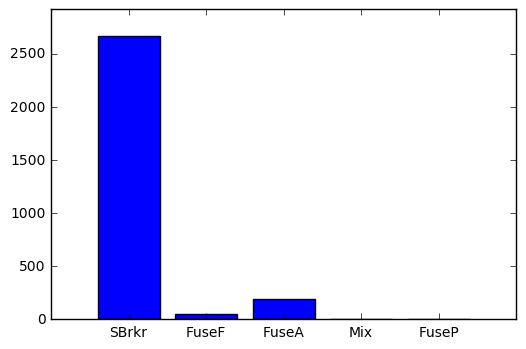

In [35]:
plot_freqs(freq_electrical.keys(), freq_electrical.values(), sum(freq_electrical.values()))

Observamos que la variable *Electrical* está muy desbalanceada, en su mayor parte las observaciones corresponden a la categoría *SBrkr*.

La categoría mayoritaria es *SBrkr*, podríamos imputar este valor, pero vamos a seguir inspeccionando los datos para asegurarnos de que elegimos el valor mas apropiado para imputar el missing detectado en esta variable.

Veamos qué valores toman algunas de las variables que intuitivamente sospechamos puedan tener relación con *Electrical*

In [56]:
miss_electrical.select(['BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 
                       'YearRemodAdd']).show(1)
                        
miss_electrical.select(['MSZoning', 'Heating', 'CentralAir', 'MiscFeature', 'Electrical']).show(1)

+--------+----------+-----------+-----------+---------+------------+
|BldgType|HouseStyle|OverallQual|OverallCond|YearBuilt|YearRemodAdd|
+--------+----------+-----------+-----------+---------+------------+
|    1Fam|      SLvl|          5|          5|     2006|        2007|
+--------+----------+-----------+-----------+---------+------------+

+--------+-------+----------+-----------+----------+
|MSZoning|Heating|CentralAir|MiscFeature|Electrical|
+--------+-------+----------+-----------+----------+
|      RL|   GasA|         Y|       None|      null|
+--------+-------+----------+-----------+----------+



La variable *MiscFeature* la hemos incluido para comprobar si la vivienda tenía alguna instalación con necesidades eléctricas especiales, pero comprobamos que no es así. 

La variable *MSZoning* la añadimos para comprobar que la vivienda no estaba situada en una zona agrícola o industrial con características especiales que pudieran influir en la instalación electrica, pero comprobamos que no es asi.

*Heating* toma el valor *GasA*, por lo que no se utiliza la instalación eléctrica para la calefacción de la vivienda, sin embargo *CentralAir* toma el valor *Y*, por lo que podría necesitar unas características especiales en cuanto a sistema eléctrico.

Después de inspeccionar los valores anteriores vamos a comprobar cómo se distribuyen las categorias de Electrical cuando la vivienda fue construida (*YearBuilt*) o remodelada (*YearRemodAdd*) a partir del año 2006. También filtraremos por las variables *OverallQual* y *OverallCond*, que nos dan idea de las calidades de la vivienda. También filtraremos por *Heating* y *CentralAir*. 

El resto de variables consultadas no las tendremos en cuenta en el filtro porque parecen bastantes genéricas y no aportan demasiada información.

In [73]:
no_miss_electrical.filter(
    ((no_miss_electrical.YearBuilt >= 2006) | (no_miss_electrical.YearRemodAdd >= 2006))&
    ((no_miss_electrical.OverallQual== 5) | (no_miss_electrical.OverallCond==5)) &
    ((no_miss_electrical.BldgType=='1Fam') | (no_miss_electrical.HouseStyle=='SLvl')) &
    (no_miss_electrical.Heating=='GasA') & (no_miss_electrical.CentralAir=='Y')).groupBy('Electrical').count().show()

+----------+-----+
|Electrical|count|
+----------+-----+
|     FuseF|    1|
|     SBrkr|  360|
+----------+-----+



Observamos que la clase *SBrkr* es mayoritaria para las características filtradas, por tanto, tomaremos *SBrkr* como valor de imputación para la observación faltante de la variable *Electrical*

In [74]:
imputation_dict['Electrical']='SBrkr'

### Variables missing *Exterior*

* **Exterior2nd**: cubierta exterior de la vivienda (si existe más de un material)
* **Exterior1st**: cubierta exterior de la vivienda

In [128]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'Exterior' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(1, 'Exterior2nd', StringType, 0.03)
(1, 'Exterior1st', StringType, 0.03)


In [77]:
miss_exterior = full.filter(full.Exterior2nd.isNull() | full.Exterior1st.isNull())
no_miss_exterior = full.filter(full.Exterior2nd.isNotNull() & full.Exterior1st.isNotNull())

Calculamos la categoría mayoritaria en la variable *Exterior1st*

In [193]:
exterior1_cat_dict={row.Exterior1st : row['count'] for row in no_miss_exterior.groupby('Exterior1st').count().collect()}
exterior1_cat_dict=sorted([(v,k) for (k,v) in exterior1_cat_dict.items()], reverse=True)
exterior1_cat_dict

[(1025, 'VinylSd'),
 (450, 'MetalSd'),
 (442, 'HdBoard'),
 (411, 'Wd Sdng'),
 (221, 'Plywood'),
 (126, 'CemntBd'),
 (87, 'BrkFace'),
 (56, 'WdShing'),
 (44, 'AsbShng'),
 (43, 'Stucco'),
 (6, 'BrkComm'),
 (2, 'Stone'),
 (2, 'CBlock'),
 (2, 'AsphShn'),
 (1, 'ImStucc')]

Calculamos la categoría mayoritaria en la variable *Exterior2nd*

In [194]:
exterior2_cat_dict={row.Exterior2nd : row['count'] for row in no_miss_exterior.groupby('Exterior2nd').count().collect()}
exterior2_cat_dict=sorted([(v,k) for (k,v) in exterior2_cat_dict.items()], reverse=True)
exterior2_cat_dict

[(1014, 'VinylSd'),
 (447, 'MetalSd'),
 (406, 'HdBoard'),
 (391, 'Wd Sdng'),
 (270, 'Plywood'),
 (126, 'CmentBd'),
 (81, 'Wd Shng'),
 (47, 'Stucco'),
 (47, 'BrkFace'),
 (38, 'AsbShng'),
 (22, 'Brk Cmn'),
 (15, 'ImStucc'),
 (6, 'Stone'),
 (4, 'AsphShn'),
 (3, 'CBlock'),
 (1, 'Other')]

Exploraremos los valores de las variables que intuimos pueden estar relacionadas con *Exterior2nd* y *Exterior1st* para el registro con valor perdido.

In [195]:
miss_exterior.select(['BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MiscFeature']).show(5)
miss_exterior.select(['RoofStyle', 'RoofMatl', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'MSZoning']).show(5)

+--------+----------+-----------+-----------+---------+------------+-----------+
|BldgType|HouseStyle|OverallQual|OverallCond|YearBuilt|YearRemodAdd|MiscFeature|
+--------+----------+-----------+-----------+---------+------------+-----------+
|    1Fam|    1Story|          5|          7|     1940|        2007|       None|
+--------+----------+-----------+-----------+---------+------------+-----------+

+---------+--------+----------+----------+---------+---------+--------+
|RoofStyle|RoofMatl|MasVnrType|MasVnrArea|ExterQual|ExterCond|MSZoning|
+---------+--------+----------+----------+---------+---------+--------+
|     Flat| Tar&Grv|      None|         0|       TA|       TA|      RL|
+---------+--------+----------+----------+---------+---------+--------+



Vamos a filtrar los valores no perdidos para encontrar un registro similar al perdido, para no hacer una búsqueda tan restrictiva, agrupamos el resto de variables que estamos inspeccionando por temática, e imponemos que las variables que representan información similar se cumpla una u otra (no ambas a la vez, uso de OR en la condición).

In [196]:
no_miss_exterior.filter( ((no_miss_exterior.BldgType == '1Fam') | (no_miss_exterior.HouseStyle == '1Story')) &
                         ((no_miss_exterior.OverallQual == 5) | (no_miss_exterior.OverallCond== 7)) &
                         ((no_miss_exterior.YearBuilt>=1940) | (no_miss_exterior.YearRemodAdd>=2007)) &
                         ((no_miss_exterior.RoofStyle == 'Flat') | (no_miss_exterior.RoofMatl == 'Tar&Grv')) &
                         ((no_miss_exterior.MasVnrType == 'None') | (no_miss_exterior.MasVnrArea == 0)) &
                         ((no_miss_exterior.ExterQual == 'TA')  | (no_miss_exterior.ExterCond == 'TA')) &
                         (no_miss_exterior.MSZoning == 'RL') ).groupBy('Exterior1st').count().show()

+-----------+-----+
|Exterior1st|count|
+-----------+-----+
|    WdShing|    1|
|    Plywood|    2|
|    Wd Sdng|    2|
|    BrkFace|    1|
+-----------+-----+



Las dos categorías más probables para el valor perdido de *Exterior1st* son: *Plywood* y *Wd Sdng*, para desempatar entre ambas nos quedamos con la categoría más frecuente entre ambas, es decir, nos quedamos con ***Wd Sdng***.

Repetimos el mismo proceso para la variable *Exterior2nd*:

In [197]:
no_miss_exterior.filter( ((no_miss_exterior.BldgType == '1Fam') | (no_miss_exterior.HouseStyle == '1Story')) &
                         ((no_miss_exterior.OverallQual == 5) | (no_miss_exterior.OverallCond== 7)) &
                         ((no_miss_exterior.YearBuilt>=1940) | (no_miss_exterior.YearRemodAdd>=2007)) &
                         ((no_miss_exterior.RoofStyle == 'Flat') | (no_miss_exterior.RoofMatl == 'Tar&Grv')) &
                         ((no_miss_exterior.MasVnrType == 'None') | (no_miss_exterior.MasVnrArea == 0)) &
                         ((no_miss_exterior.ExterQual == 'TA')  | (no_miss_exterior.ExterCond == 'TA')) &
                         (no_miss_exterior.MSZoning == 'RL') ).groupBy('Exterior2nd').count().show()

+-----------+-----+
|Exterior2nd|count|
+-----------+-----+
|    Plywood|    3|
|    Wd Shng|    1|
|    Wd Sdng|    2|
+-----------+-----+



En este caso la categoría más frecuente es ***Plywood***.

Guardamos los valores a imputar en el diccionario *imputation_dict*

In [198]:
imputation_dict['Exterior1st'] = 'Wd Sdng'
imputation_dict['Exterior2nd'] = 'Plywood'

### Variables missing *Garage*

* **GarageYrBlt**: año en el que fue construido el garage
* **GarageCars**: tamaño del garage según capacidad de coches
* **GarageArea**: tamaño del garage (ft2)

In [127]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'Garage' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(159, 'GarageYrBlt', IntegerType, 5.45)
(1, 'GarageCars', IntegerType, 0.03)
(1, 'GarageArea', IntegerType, 0.03)


Vamos a estudiar en primer lugar los missings de las variables *GarageCars* y *GarageArea* que sólo presentan una observación y a continuación analizaremos los 159 registros con valores perdidos de la variable *GarageYrBlt*

In [113]:
miss_garage = full.filter(full.GarageCars.isNull() | full.GarageArea.isNull())
no_miss_garage = full.filter(full.GarageCars.isNotNull() & full.GarageArea.isNotNull())

In [114]:
miss_garage.select(['GarageQual',
                    'GarageCond',
                    'GarageType',
                    'GarageFinish',
                    'GarageCars',
                    'GarageArea',
                    'GarageYrBlt']).show(5)

+----------+----------+----------+------------+----------+----------+-----------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|
+----------+----------+----------+------------+----------+----------+-----------+
|  NoGarage|  NoGarage|    Detchd|    NoGarage|      null|      null|       null|
+----------+----------+----------+------------+----------+----------+-----------+



Observamos que los valores perdidos de las variables *GarageCars* y *GarageArea* pertenecen a la misma observación. En dicha observación el resto de variables relativas al garage nos informan de la no existencia de garage. En ese caso el tamaño del garage, que es lo que representan las variables que estamos estudiando, será igual a 0. 

Por tanto, decidimos imputar el valor 0 a los valores perdidos de las variables *GarageCars* y *GarageArea*, lo añadimos al diccionario *imputation_dict*.

En la inspección anterior vemos que la variable *GarageType* toma el valor *Detchd* (garage independiente a la vivienda), mientras que el resto de variables relativas al garage (*GarageQual*, *GarageCond*, etc.) toman el valor *NoGarage*, este registro no parece consistente, el valor de *GarageType* debería ser también *NoGarage*

In [144]:
miss_garage.select(['GarageQual',
                    'GarageCond',
                    'GarageType',
                    'GarageFinish',
                    'GarageCars',
                    'GarageArea',
                    'GarageYrBlt', 
                    'SalePrice']).show(5)

+----------+----------+----------+------------+----------+----------+-----------+---------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|SalePrice|
+----------+----------+----------+------------+----------+----------+-----------+---------+
|  NoGarage|  NoGarage|    Detchd|    NoGarage|      null|      null|       null|     null|
+----------+----------+----------+------------+----------+----------+-----------+---------+



El valor de *SalePrice* en este registro es null, lo que quiere decir que el resgistro pertenece al conjunto test, y por tanto, no vamos a modificar a modificar el dataset, pero sí habrá que tenerlo en cuenta a la hora de realizar las predicciones con el modelo que construyamos.

In [145]:
imputation_dict['GarageCars']=0
imputation_dict['GarageArea']=0

A continuación analizaremos los valores perdidos de la variable *GarageYrBlt*

In [146]:
miss_garageYearBlt = full.filter(full.GarageYrBlt.isNull())
no_miss_garageYearBlt = full.filter(full.GarageYrBlt.isNotNull())

In [147]:
miss_garageYearBlt.select(['GarageQual',
                           'GarageCond',
                           'GarageType',
                           'GarageFinish',
                           'GarageCars',
                           'GarageArea',
                           'GarageYrBlt']).show(10)

+----------+----------+----------+------------+----------+----------+-----------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|
+----------+----------+----------+------------+----------+----------+-----------+
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  NoGarage|  NoGarage|    NoGarage|         0|         0|       null|
|  NoGarage|  No

Observamos que la variable *GarageYrBlt* no toma ningún valor si la vivienda no tiene garage, evidentemente, si no tiene garage, la variable que representa el año en el que se construyo el garage carece de sentido.

Vamos a explorar los registros qu sí tienen valor para *GarageYrBlt* en busca de un año por defecto que haya sido introducido cuando la vivienda no tiene garage

In [148]:
no_miss_garageYearBlt.select('GarageQual','GarageCond', 'GarageType', 'GarageFinish', \
                             'GarageCars', 'GarageArea', 'GarageYrBlt')\
                     .filter((no_miss_garageYearBlt.GarageQual=='NoGarage')  | 
                             (no_miss_garageYearBlt.GarageCond=='NoGarage')  |
                             (no_miss_garageYearBlt.GarageType =='NoGarage') |
                             (no_miss_garageYearBlt.GarageFinish =='NoGarage') |
                             (no_miss_garageYearBlt.GarageCars == 0) |
                             (no_miss_garageYearBlt.GarageArea == 0)).show()

+----------+----------+----------+------------+----------+----------+-----------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|
+----------+----------+----------+------------+----------+----------+-----------+
+----------+----------+----------+------------+----------+----------+-----------+



Vemos que no hay un valor por defecto para el año de construcción del garage cuando la vivienda no tiene garage.

A continuación vamos a obtener la descripción de esta variable en la parte del dataset que no tiene valores perdidos.

In [149]:
no_miss_garageYearBlt.describe('GarageYrBlt').show()

+-------+------------------+
|summary|       GarageYrBlt|
+-------+------------------+
|  count|              2760|
|   mean|1978.1134057971014|
| stddev|25.574284723905112|
|    min|              1895|
|    max|              2207|
+-------+------------------+



Obtenemos un valor medio aproximado de año de construcción igual a *1978*. Un valor mínimo igual 1895 y un casualmente encontramos un valor máximo que representa un año en el futuro, parece que existe un outlier en la variable *GarageYrBlt*

In [150]:
train.select('GarageQual','GarageCond', 'GarageType', 'GarageFinish', 
            'GarageCars', 'GarageArea', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd').filter(train.GarageYrBlt>2017).show()

+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|YearBuilt|YearRemodAdd|
+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
+----------+----------+----------+------------+----------+----------+-----------+---------+------------+



In [151]:
test.select('GarageQual','GarageCond', 'GarageType', 'GarageFinish', 
            'GarageCars', 'GarageArea', 'GarageYrBlt', 'YearBuilt', 'YearRemodAdd').filter(test.GarageYrBlt>2017).show()

+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
|GarageQual|GarageCond|GarageType|GarageFinish|GarageCars|GarageArea|GarageYrBlt|YearBuilt|YearRemodAdd|
+----------+----------+----------+------------+----------+----------+-----------+---------+------------+
|        TA|        TA|    Attchd|         RFn|         2|       502|       2207|     2006|        2007|
+----------+----------+----------+------------+----------+----------+-----------+---------+------------+



El outlier está en el conjunto test, por lo que habrá que tenerlo en cuenta a la hora de calcular las predicciones sobre este conjunto de datos una vez haymos construido y ajustado nuestro modelo. Una buena opción para corregir este registro es dar el valor *2007*, ya que a la vista de los datos, la vivienda fue construida en 2006 y remodelada en el 2007 y en ese momento se construyó el garage, parece que hay una errata en un número en lugar de 2207 debería ser 2007.


Tenemos varias alternativas a la hora de solucionar los 159 registros missing de la variable *GarageYrBlt*. 
* Imputar la media de los años = 1978
* Imputar un 0 para indicar que si la vivienda no tiene garage, el año es un valor atípico
* Eliminar la variable *GarageYrBlt*
* Predecir el año usuando árboles de decisión

Ninguna de las soluciones es buena, podríamos eliminar la variable que es lo más sencillo, pero probaremos a dar el valor 0, ya que el porcentage de registros faltantes en esta variable es bajo (5,45%) y podría proporcionar información en la construcción del modelo. Tomar la media de los años también puede introducir error. Por tanto, tomaremos 0 como valor para imputar, y en función de los resultados que obtengamos con el modelo realizaremos pruebas de imputación con otros valores diferentes.

In [152]:
imputation_dict['GarageYrBlt'] = 0

### Variable missing *KitchenQual*

* **KitchenQual**: Calidad de la cocina (Ex, Gd, TA, Fa, Po)

In [199]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'KitchenQual' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(1, 'KitchenQual', StringType, 0.03)


In [201]:
miss_kitchen = full.filter(full.KitchenQual.isNull())
no_miss_kitchen = full.filter(full.KitchenQual.isNotNull())

Comprobemos cual es la clase mayoritaria para *KitchenQual* para las observaciones donde no existen valores perdidos:

In [209]:
kitchen_cat_dict={row.KitchenQual : row['count'] for row in no_miss_kitchen.groupby('KitchenQual').count().collect()}
kitchen_cat_dict=sorted([(v,k) for (k,v) in kitchen_cat_dict.items()], reverse=True)
kitchen_cat_dict

[(1492, 'TA'), (1151, 'Gd'), (205, 'Ex'), (70, 'Fa')]

La clase mayoritaria es *TA*, vamos a seguir inspeccionando para confirmar si este es un buen valor para imputar o no.

Las variables que intuitivamente podrían estar relacionadas con la calidad de la cocina son:

In [203]:
miss_kitchen.select(['Utilities',
                     'OverallQual',
                     'OverallCond',
                     'MasVnrType',
                     'MasVnrArea',
                     'Electrical',
                     'KitchenAbvGr',
                     'YearBuilt',
                     'YearRemodAdd',
                     'KitchenQual']).show(10)

+---------+-----------+-----------+----------+----------+----------+------------+---------+------------+-----------+
|Utilities|OverallQual|OverallCond|MasVnrType|MasVnrArea|Electrical|KitchenAbvGr|YearBuilt|YearRemodAdd|KitchenQual|
+---------+-----------+-----------+----------+----------+----------+------------+---------+------------+-----------+
|   AllPub|          5|          3|      None|         0|     SBrkr|           1|     1917|        1950|       null|
+---------+-----------+-----------+----------+----------+----------+------------+---------+------------+-----------+



Veamos si encontramos un registro similar entre las observaciones del conjunto donde no hay valores perdidos para *KitchenQual*

In [208]:
no_miss_kitchen.select(['Utilities', 'OverallQual', 'OverallCond', 'MasVnrType','MasVnrArea',
                        'Electrical', 'KitchenAbvGr', 'YearBuilt', 'YearRemodAdd', 'KitchenQual'])\
               .filter((no_miss_kitchen.Utilities=='AllPub')  & 
                       (no_miss_kitchen.OverallQual==5)  &
                       (no_miss_kitchen.OverallCond ==3) &
                       (no_miss_kitchen.MasVnrType =='None') &
                       (no_miss_kitchen.MasVnrArea == 0) &
                       (no_miss_kitchen.Electrical == 'SBrkr') &
                       (no_miss_kitchen.KitchenAbvGr == 1) &
                       (no_miss_kitchen.YearBuilt >= 1917) &
                       (no_miss_kitchen.YearRemodAdd == 1950)).show()

+---------+-----------+-----------+----------+----------+----------+------------+---------+------------+-----------+
|Utilities|OverallQual|OverallCond|MasVnrType|MasVnrArea|Electrical|KitchenAbvGr|YearBuilt|YearRemodAdd|KitchenQual|
+---------+-----------+-----------+----------+----------+----------+------------+---------+------------+-----------+
|   AllPub|          5|          3|      None|         0|     SBrkr|           1|     1936|        1950|         TA|
+---------+-----------+-----------+----------+----------+----------+------------+---------+------------+-----------+



Hemos obtenido un registro muy similar para el que la variable *KitchenQual* toma el valor *TA*, que además coincide con la categoría mayoritaria, por lo que imputaremos este valor.

Lo almacenamos en nuestro diccionario:

In [210]:
imputation_dict['KitchenQual']= 'TA'

### Variable missing *SaleType*

* **SaleType**: Tipo de venta (tipo de contrato, intereses, garantías, etc.)

In [211]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'SaleType' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(1, 'SaleType', StringType, 0.03)


In [213]:
miss_saletype = full.filter(full.SaleType.isNull())
no_miss_saletype = full.filter(full.SaleType.isNotNull())

In [214]:
saletype_cat_dict={row.SaleType : row['count'] for row in no_miss_saletype.groupby('SaleType').count().collect()}
saletype_cat_dict=sorted([(v,k) for (k,v) in saletype_cat_dict.items()], reverse=True)
saletype_cat_dict

[(2525, 'WD'),
 (239, 'New'),
 (87, 'COD'),
 (26, 'ConLD'),
 (12, 'CWD'),
 (9, 'ConLI'),
 (8, 'ConLw'),
 (7, 'Oth'),
 (5, 'Con')]

La categoría mayoritaria con bastante diferencia es *WD*. 

Las variables con las que podría estar relacionada esta variable son:

In [216]:
miss_saletype.select(['MoSold',
                      'YrSold',
                      'SaleCondition',
                      'MSSubClass',
                      'Neighborhood',
                      'MSZoning',
                      'SaleType']).show(10)

+------+------+-------------+----------+------------+--------+--------+
|MoSold|YrSold|SaleCondition|MSSubClass|Neighborhood|MSZoning|SaleType|
+------+------+-------------+----------+------------+--------+--------+
|    10|  2007|       Normal|        20|      Sawyer|      RL|    null|
+------+------+-------------+----------+------------+--------+--------+



In [218]:
no_miss_saletype.select(['MoSold', 'YrSold', 'SaleCondition', 'MSSubClass', 'Neighborhood', 'MSZoning', 'SaleType'])\
                .filter((no_miss_saletype.MoSold== 10)  & 
                        (no_miss_saletype.YrSold== 2007)  &
                        (no_miss_saletype.SaleCondition == 'Normal') &
                        (no_miss_saletype.MSSubClass == 20) &
                        (no_miss_saletype.Neighborhood == 'Sawyer') &
                        (no_miss_saletype.MSZoning == 'RL') ).show()

+------+------+-------------+----------+------------+--------+--------+
|MoSold|YrSold|SaleCondition|MSSubClass|Neighborhood|MSZoning|SaleType|
+------+------+-------------+----------+------------+--------+--------+
|    10|  2007|       Normal|        20|      Sawyer|      RL|      WD|
|    10|  2007|       Normal|        20|      Sawyer|      RL|      WD|
+------+------+-------------+----------+------------+--------+--------+



Hemos encontrado dos registros con características muy similares al del valor perdido y para los cuales la variable *SaleType* toma el valor *WD*. Por tanto, elegiremos dicha categoría para imputar, que como vimos además es la mayoritaria.

In [219]:
imputation_dict['SaleType']='WD'

### Variable missing *Functional*

* **Functional**: Mide el grado de funcionalidad de la vivienda (asume siempre la categoría típica a menos que se justifique que carece de alguna característica)

In [133]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'Functional' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(2, 'Functional', StringType, 0.07)


In [220]:
miss_functional = full.filter(full.Functional.isNull())
no_miss_functional = full.filter(full.Functional.isNotNull())

Calculemos la clase mayoritaria:

In [221]:
functional_cat_dict={row.Functional : row['count'] for row in no_miss_functional.groupby('Functional').count().collect()}
functional_cat_dict=sorted([(v,k) for (k,v) in functional_cat_dict.items()], reverse=True)
functional_cat_dict

[(2717, 'Typ'),
 (70, 'Min2'),
 (65, 'Min1'),
 (35, 'Mod'),
 (19, 'Maj1'),
 (9, 'Maj2'),
 (2, 'Sev')]

La clase mayoritaria es *Typ*.
Esta variable puede estar relacionada con muchas otras, porque es bastante genérica, dado que son solo 2 valores perdidos vamos a inspeccionar todas las variables y veamos si la vivienda en cuestión carece de alguna de funcionalidad, y si no es así le asignaremos la clase mayoritaria *Typ*

In [224]:
step=7
for index in range(0, num_columns, step):
    miss_functional.select(cols[index:index+step]).show(5) 

+----+----------+--------+-----------+-------+------+--------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|   Alley|
+----+----------+--------+-----------+-------+------+--------+
|2217|        20|    null|         80|  14584|  Pave|noAccess|
|2474|        50|      RM|         60|  10320|  Pave|    Grvl|
+----+----------+--------+-----------+-------+------+--------+

+--------+-----------+---------+---------+---------+------------+----------+
|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|
+--------+-----------+---------+---------+---------+------------+----------+
|     Reg|        Low|   AllPub|   Inside|      Mod|      IDOTRR|      Norm|
|     Reg|        Lvl|   AllPub|   Corner|      Gtl|      IDOTRR|    Artery|
+--------+-----------+---------+---------+---------+------------+----------+

+----------+--------+----------+-----------+-----------+---------+------------+
|Condition2|BldgType|HouseStyle|OverallQual|OverallCond|YearBuilt|YearRemodAdd

Las viviendas disponen de las características mínimas, tienen dormitorios, cocina, todos los suministros, instalación electrica, baños, etc. No dispone de características extra como piscina, sótano, garage, valla, etc.

Por tanto, asignaremos la clase mayoritaria *Typ*

In [225]:
imputation_dict['Functional']='Typ'

### Variable missing *Utilities*

* **Utilities**: Tipo de suministros disponibles (agua, luz, gas, etc.)

In [226]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'Utilities' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(2, 'Utilities', StringType, 0.07)


In [227]:
miss_utilities = full.filter(full.Utilities.isNull())
no_miss_utilities = full.filter(full.Utilities.isNotNull())

Calculamos la clase mayoritaria para *Utilities*

In [228]:
utilities_cat_dict={row.Utilities : row['count'] for row in no_miss_utilities.groupby('Utilities').count().collect()}
utilities_cat_dict=sorted([(v,k) for (k,v) in utilities_cat_dict.items()], reverse=True)
utilities_cat_dict

[(2916, 'AllPub'), (1, 'NoSeWa')]

En este caso vamos a asignar la clase mayoritaria para imputar, ya que claramente es la única clase existente en los datos.

In [229]:
imputation_dict['Utilities']='AllPub'

### Variable missing *MSZoning*

* **MSZoning**: Identifica la clasificación de la vivienda según la zona en la que está ubicada (agrícola, comercial, residencial, industrial, etc.)

In [230]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'MSZoning' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(4, 'MSZoning', StringType, 0.14)


In [231]:
miss_zoning = full.filter(full.MSZoning.isNull())
no_miss_zoning = full.filter(full.MSZoning.isNotNull())

In [232]:
zoning_cat_dict={row.MSZoning : row['count'] for row in no_miss_zoning.groupby('MSZoning').count().collect()}
zoning_cat_dict=sorted([(v,k) for (k,v) in zoning_cat_dict.items()], reverse=True)
zoning_cat_dict

[(2265, 'RL'), (460, 'RM'), (139, 'FV'), (26, 'RH'), (25, 'C (all)')]

La clase mayoritaria es *RL*, es decir, zona residencial de baja densidad.

Las variable que más informacíon nos podría dar para encontrar el mejor valor para los valores perdidos de la variable *MSZoning* es *Neighborhood*, por tanto veamos el vecindario al que pertenecen las viviendas que presentan valores perdidos.

In [234]:
miss_zoning.select(['Neighborhood']).show(10)

+------------+
|Neighborhood|
+------------+
|      IDOTRR|
|      IDOTRR|
|      IDOTRR|
|     Mitchel|
+------------+



Vemos que las viviendas están ubicadas en el barrio *IDOTRR* o *Mitchel*, a continuación calculemos cuál es la calificación del suelo para estos barrios y le asignaremos esa categoría a los valores perdidos.

In [239]:
no_miss_zoning.filter((no_miss_zoning.Neighborhood=='IDOTRR') | 
                      (no_miss_zoning.Neighborhood=='Mitchel')).groupBy('MSZoning').count().show()

+--------+-----+
|MSZoning|count|
+--------+-----+
| C (all)|   22|
|      RL|  104|
|      RM|   77|
+--------+-----+



Imputaremos el valor *RL*

In [240]:
imputation_dict['MSZoning']='RL'

### Variables missing *MasVnr*

* **MasVnrType**: Tipo de revestimiento (ladrillo, ladrillo visto, piedra, etc.)
* **MasVnrArea**: superficie de revestimiento (ft2)

In [138]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'MasVnr' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(24, 'MasVnrType', StringType, 0.82)
(23, 'MasVnrArea', IntegerType, 0.79)


In [241]:
miss_masvnr = full.filter(full.MasVnrType.isNull() | full.MasVnrArea.isNull() )
no_miss_masvnr = full.filter(full.MasVnrType.isNotNull() & full.MasVnrArea.isNotNull())

Calculamos la clase mayoritaria para la variable *MasVnrType*

In [242]:
masvnr_cat_dict={row.MasVnrType : row['count'] for row in no_miss_masvnr.groupby('MasVnrType').count().collect()}
masvnr_cat_dict=sorted([(v,k) for (k,v) in masvnr_cat_dict.items()], reverse=True)
masvnr_cat_dict

[(1742, 'None'), (879, 'BrkFace'), (249, 'Stone'), (25, 'BrkCmn')]

La clase mayoritaria es *None*.

Veamos los valores que toman las variables que podrían estar relacionadas con *MasVnrArea* y *MasVnrType* para las observaciones missing:

In [245]:
miss_masvnr.select(['MSSubClass',
                    'Neighborhood',
                    'OverallQual',
                    'OverallCond',
                    'YearBuilt',
                    'Exterior1st',
                    'Exterior2nd',
                    'ExterQual',
                    'ExterCond',
                    'MasVnrType',
                    'MasVnrArea']).show(25)

+----------+------------+-----------+-----------+---------+-----------+-----------+---------+---------+----------+----------+
|MSSubClass|Neighborhood|OverallQual|OverallCond|YearBuilt|Exterior1st|Exterior2nd|ExterQual|ExterCond|MasVnrType|MasVnrArea|
+----------+------------+-----------+-----------+---------+-----------+-----------+---------+---------+----------+----------+
|        60|     Gilbert|          6|          5|     2002|    VinylSd|    VinylSd|       Gd|       TA|      null|      null|
|        20|     Crawfor|          6|          3|     1957|    Wd Sdng|      Stone|       Gd|       TA|      null|      null|
|        60|     Somerst|          7|          6|     2007|    CemntBd|    CmentBd|       Gd|       TA|      null|      null|
|        20|     SawyerW|          7|          5|     2003|    VinylSd|    VinylSd|       Gd|       TA|      null|      null|
|        20|     Somerst|          7|          5|     2007|    CemntBd|    CmentBd|       Gd|       TA|      null|    

Vamos a buscar los registros similares en el dataframe sin valores perdidos

In [253]:
no_miss_masvnr.select(['MSSubClass', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearBuilt',
                       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'MasVnrType', 'MasVnrArea'])\
                .filter((no_miss_masvnr.ExterCond=='TA') &
                        (no_miss_masvnr.ExterQual=='Gd') &
                        (no_miss_masvnr.Exterior2nd=='VinylSd') &
                        (no_miss_masvnr.Exterior1st=='VinylSd') &
                        ((no_miss_masvnr.YearBuilt>=1957) & (no_miss_masvnr.YearBuilt<=2007)) &
                        (no_miss_masvnr.OverallCond==5) &
                        (no_miss_masvnr.OverallQual>=6) & 
                        (no_miss_masvnr.OverallQual<=8) &
                        ((no_miss_masvnr.Neighborhood=='Gilbert') | (no_miss_masvnr.Neighborhood=='Crawfor') | 
                         (no_miss_masvnr.Neighborhood=='Somerst') | (no_miss_masvnr.Neighborhood=='NridgHt') | 
                         (no_miss_masvnr.Neighborhood=='CollgCr')) &
                        ((no_miss_masvnr.MSSubClass==60) | (no_miss_masvnr.MSSubClass==20))).groupBy('MasVnrType').count().show()

+----------+-----+
|MasVnrType|count|
+----------+-----+
|      None|  151|
|     Stone|   49|
|   BrkFace|  125|
+----------+-----+



La mayoria de las observaciones similares tiene como categoría mayoritaria *None*, por tanto utilizaremos este valor para imputar *MasVnrType*. Veamos qué valor damos a *MasVnrArea*.

In [255]:
no_miss_masvnr.select(['MasVnrType', 'MasVnrArea']).filter(no_miss_masvnr.MasVnrType=='None').show(5)

+----------+----------+
|MasVnrType|MasVnrArea|
+----------+----------+
|      None|         0|
|      None|         0|
|      None|         0|
|      None|         0|
|      None|         0|
+----------+----------+
only showing top 5 rows



In [257]:
no_miss_masvnr.select(['MasVnrType', 'MasVnrArea']).filter(no_miss_masvnr.MasVnrType=='None').groupBy('MasVnrType').count().show(5)

+----------+-----+
|MasVnrType|count|
+----------+-----+
|      None| 1742|
+----------+-----+



Todas las observaciones con valor *MasVnrType* igual a *None*, les corresponde un valor de *MasVnrArea* igual a 0, por tanto imputaremos los siguientes valores:

In [262]:
imputation_dict['MasVnrType']='None'
imputation_dict['MasVnrArea']=0

### Variable missing *LotFrontage*

* **LotFrontage**: longitud de la calle en la que se encuentra la propiedad

In [263]:
print('Rows    Variable    Datatype    Percent\n')
for i in range(len(missings)):
    if 'LotFrontage' in missings[i][1]:
        print(missings[i])

Rows    Variable    Datatype    Percent

(486, 'LotFrontage', IntegerType, 16.65)


Esta variable presenta un alto porcentaje de valores perdidos (16,65%), por tanto, vamos a eliminarla del estudio, porque imputar tantos valores podría introducir error o sesgar los resultados.

### Imputación de valores perdidos

Añadimos al diccionario imputation_dict los valores de las categorías NA válidas pero que hemos renombrado para más claridad

In [264]:
imputation_dict.update(new_NA_categories)

Los valores por los que imputamos cada una de las variables missing a continuación

In [265]:
imputation_dict

{'Alley': 'noAccess',
 'BsmtCond': 'NoBasement',
 'BsmtExposure': 'NoBasement',
 'BsmtFinSF1': 0,
 'BsmtFinSF2': 0,
 'BsmtFinType1': 'NoBasement',
 'BsmtFinType2': 'NoBasement',
 'BsmtFullBath': 0,
 'BsmtHalfBath': 0,
 'BsmtQual': 'NoBasement',
 'BsmtUnfSF': 0,
 'Electrical': 'SBrkr',
 'Exterior1st': 'Wd Sdng',
 'Exterior2nd': 'Plywood',
 'Fence': 'NoFence',
 'FireplaceQu': 'NoFireplace',
 'Functional': 'Typ',
 'GarageArea': 0,
 'GarageCars': 0,
 'GarageCond': 'NoGarage',
 'GarageFinish': 'NoGarage',
 'GarageQual': 'NoGarage',
 'GarageType': 'NoGarage',
 'GarageYrBlt': 0,
 'KitchenQual': 'TA',
 'MSZoning': 'RL',
 'MasVnrArea': 0,
 'MasVnrType': 'None',
 'MiscFeature': 'None',
 'PoolQC': 'NoPool',
 'SaleType': 'WD',
 'TotalBsmtSF': 0,
 'Utilities': 'AllPub'}

En este punto nos olvidaremos del conjunto test, sólo lo retomaremos para calcular las predicciones que subiremos a Kaggle. Imputaremos los valores perdidos en el conjunto train, utilizando la función *fillna* y el diccionario que hemos construido en los apartados anteriores.

In [266]:
imputed_df=train.fillna(imputation_dict)

A continuación borraremos la variable *LotFrontage* del dataframe de entrenamiento, tal y como vimos el porcentaje de valores perdidos es muy elevado, y hemos tomado la decisión de prescindir de dicha variable para nuestro estudio.

In [270]:
imputed_df2 = imputed_df.drop('LotFrontage')

Por último comprobamos que en el conjunto train ya no existen valores perdidos

In [272]:
sorted([(v, k) for k, v in imputed_df2.agg(*[count_nulls(c) for c in imputed_df2.columns]).first().asDict().items() if v > 0], reverse=True)

[]

Vamos a guardar nuestro dataset train ya limpio de valores perdidos en un fichero csv para poder usarlo en cualquier momento

In [275]:
path = 'data/output/imputed_df_csv'
imputed_df2.write.csv(path, header=True, mode='overwrite')

<a id="preprocesado"></a>

# 5. Preprocesado

En primer lugar recuperamos el conjunto de datos ya limpio de missings

In [71]:
path = 'data/output/imputed_df_csv'
imputed_train_data = spark.read.csv(path, header=True, inferSchema=True).cache()

<a id="numerico"></a>

## 5.2 Conversión a tipo numérico

Para construir modelos es necesario convertir a numéricas las variables.

Vamos a usar *StringIndexer* para automatizar el proceso

In [72]:
imputed_train_data.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-- Exterior2nd: string (nullable = true)
 |--

In [73]:
all_features=imputed_train_data.columns

# Vector con las variables numéricas
num_var=[var for var in all_features if type(imputed_train_data.schema[var].dataType)==IntegerType]

# Vector con las variables categóricas
categ_var=[var for var in all_features if type(imputed_train_data.schema[var].dataType)==StringType]

print('Número de variables numéricas = {}'.format(len(num_var)))
print('Número de variables categóricas = {} '.format(len(categ_var)))


Número de variables numéricas = 37
Número de variables categóricas = 43 


In [74]:
num_var

['Id',
 'MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [75]:
indexers=[StringIndexer(inputCol= var, outputCol=var + '_n') for var in var_categ]

<a id="seleccion"></a>

# 6. Selección de variables 

(correlaciones, importancia de variables)

In [76]:
selected_features = num_var + [c+'_n' for c in categ_var]
selected_features

['Id',
 'MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'MSZoning_n',
 'Street_n',
 'Alley_n',
 'LotShape_n',
 'LandContour_n',
 'Utilities_n',
 'LotConfig_n',
 'LandSlope_n',
 'Neighborhood_n',
 'Condition1_n',
 'Condition2_n',
 'BldgType_n',
 'HouseStyle_n',
 'RoofStyle_n',
 'RoofMatl_n',
 'Exterior1st_n',
 'Exterior2nd_n',
 'MasVnrType_n',
 'ExterQual_n',
 'ExterCond_n',
 'Foundation_n',
 'BsmtQual_n',
 'BsmtCond_n',
 'BsmtExposure_n',
 'BsmtFinType1_n',
 'BsmtFinType2_n',
 'Heating_n',
 'HeatingQC_n',
 'C

<a id="features"></a>

## 5.4 Convertir features en vector

In [78]:
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")

<a id="escalado"></a>

## 5.3 Escalado

Usamos la clase StandardScaler para escalar nuestro vector de características.

In [79]:
standard_scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaledFeatures')
standard_scaler

StandardScaler_42a6a26a406e68972b05

## 5.4 Pipeline preprocesado

In [80]:
preprocessing_stages= indexers + [assembler, standard_scaler]
preprocessing_stages

[StringIndexer_4e74ac15ec078441439e,
 StringIndexer_4459be9a707846e8f08c,
 StringIndexer_4c7f84e0182107f509e1,
 StringIndexer_43ef8fc4d1775c2aaa06,
 StringIndexer_4cdfaa7ee52da1e62a42,
 StringIndexer_4ab589d17c15525bd7b6,
 StringIndexer_4fd58846bf8077c5454a,
 StringIndexer_4d529dbc38cf8124579e,
 StringIndexer_4444ad8c15294ebcdee1,
 StringIndexer_4656b7ada840c980f474,
 StringIndexer_48379e3d663fa26faf16,
 StringIndexer_4bbb9d182200a2b3c80e,
 StringIndexer_46f991c1cd64fe3588ab,
 StringIndexer_4e39944d1322ac951a79,
 StringIndexer_4b5ab608050b0e0ce322,
 StringIndexer_4302b39e31456397e364,
 StringIndexer_44649dab72e2d8595dc2,
 StringIndexer_43bfbe351121d24818b6,
 StringIndexer_49c68f46b0523d2903cf,
 StringIndexer_4a4a9e247c0ebec885d6,
 StringIndexer_46cf92e538479ef3eb69,
 StringIndexer_48b4baec1729c4681694,
 StringIndexer_4a998465814244d74563,
 StringIndexer_411c99a8b41978b0a5e5,
 StringIndexer_430a91ba1e89030f308b,
 StringIndexer_4442a47a5e6292268493,
 StringIndexer_46f7b9d7638761d922ac,
 

In [81]:
pipeline = Pipeline(stages=preprocessing_stages)
pipeline

Pipeline_4d47b2adc2fe884df652

In [82]:
preprocessing_pl = pipeline.fit(imputed_train_data)
preprocessing_pl

PipelineModel_4dbb8b027676b12e082b

In [86]:
preprocesed_df=preprocessing_pl.transform(imputed_train_data)

preprocesed_columns=selected_features + ['features', 'scaledFeatures']

step=7
for index in range(0, len(preprocesed_columns), step):
    preprocesed_df.select(preprocesed_columns[index:index+step]).show(5) 


+---+----------+-------+-----------+-----------+---------+------------+
| Id|MSSubClass|LotArea|OverallQual|OverallCond|YearBuilt|YearRemodAdd|
+---+----------+-------+-----------+-----------+---------+------------+
|  1|        60|   8450|          7|          5|     2003|        2003|
|  2|        20|   9600|          6|          8|     1976|        1976|
|  3|        60|  11250|          7|          5|     2001|        2002|
|  4|        70|   9550|          7|          5|     1915|        1970|
|  5|        60|  14260|          8|          5|     2000|        2000|
+---+----------+-------+-----------+-----------+---------+------------+
only showing top 5 rows

+----------+----------+----------+---------+-----------+--------+--------+
|MasVnrArea|BsmtFinSF1|BsmtFinSF2|BsmtUnfSF|TotalBsmtSF|1stFlrSF|2ndFlrSF|
+----------+----------+----------+---------+-----------+--------+--------+
|       196|       706|         0|      150|        856|     856|     854|
|         0|       978|    

In [100]:
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
import pandas as pd

test_df=preprocesed_df.select(selected_features)
preprocesed_rdd = test_df.rdd.map(Vectors.dense) ### convertimos a rdd

pearson_corr = Statistics.corr(preprocesed_rdd, method="pearson")
pearson_corr_df = pd.DataFrame(pearson_corr, index=selected_features, columns=selected_features)
pearson_corr_df

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType_n,GarageFinish_n,GarageQual_n,GarageCond_n,PavedDrive_n,PoolQC_n,Fence_n,MiscFeature_n,SaleType_n,SaleCondition_n
Id,1.000000,0.011156,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.051071,-0.005024,-0.005968,...,-0.004256,-0.000034,-0.012676,0.000568,0.008921,0.043368,0.004620,-0.014074,-0.020018,-0.016834
MSSubClass,0.011156,1.000000,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.023573,-0.069836,-0.065649,...,0.164193,0.052038,0.055006,0.040650,0.025973,-0.001113,-0.100303,-0.016437,0.014963,0.004788
LotArea,-0.033226,-0.139781,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103321,0.214103,0.111170,...,-0.066204,0.046625,-0.040210,-0.055792,-0.002964,0.058232,-0.035421,0.089707,-0.012098,-0.016193
OverallQual,-0.028365,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.407252,0.239666,-0.059119,...,-0.293393,0.275131,-0.160127,-0.226272,-0.200702,0.062375,-0.170554,-0.083121,0.075002,0.002462
OverallCond,0.012609,-0.059316,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.046231,0.040229,...,0.003521,-0.173026,0.086357,0.023459,0.082132,-0.015231,0.142421,0.061981,-0.105673,-0.125835
YearBuilt,-0.012713,0.027850,0.014228,0.572323,-0.375983,1.000000,0.592855,0.311600,0.249503,-0.049107,...,-0.321568,0.342565,-0.349503,-0.317723,-0.396023,0.001374,-0.193985,-0.070932,0.081609,0.015943
YearRemodAdd,-0.021998,0.040581,0.013788,0.550684,0.073741,0.592855,1.000000,0.176529,0.128451,-0.067759,...,-0.182247,0.313004,-0.159714,-0.195652,-0.193616,0.011973,-0.146553,-0.087934,0.039722,-0.017517
MasVnrArea,-0.051071,0.023573,0.103321,0.407252,-0.125694,0.311600,0.176529,1.000000,0.261256,-0.071330,...,-0.123286,0.146081,-0.139110,-0.111800,-0.140724,0.008207,-0.071418,-0.044700,0.033930,0.015323
BsmtFinSF1,-0.005024,-0.069836,0.214103,0.239666,-0.046231,0.249503,0.128451,0.261256,1.000000,-0.050117,...,-0.197154,0.134247,-0.146226,-0.133057,-0.175379,0.117715,-0.000065,-0.006777,0.019767,0.005293
BsmtFinSF2,-0.005968,-0.065649,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.071330,-0.050117,1.000000,...,-0.040819,-0.051147,-0.049336,-0.023178,-0.067842,0.069478,0.109056,0.009178,0.012186,-0.020424


In [105]:
import numpy as np
corr_matrix = pearson_corr_df.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
os = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .order(ascending=False))
os

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: order is deprecated, use sort_values(...)


GarageCars      GarageArea         0.992319
PoolArea        PoolQC_n           0.984986
OverallQual     SalePrice          0.977946
Exterior1st_n   Exterior2nd_n      0.976516
TotalBsmtSF     1stFlrSF           0.960093
YearBuilt       Foundation_n       0.959001
GrLivArea       TotRmsAbvGrd       0.954359
Fireplaces      FireplaceQu_n      0.944685
GarageQual_n    GarageCond_n       0.936125
GarageCars      SalePrice          0.927634
OverallQual     GarageCars         0.925913
GarageArea      SalePrice          0.924793
YearRemodAdd    Foundation_n       0.924661
MasVnrArea      MasVnrType_n       0.923286
YearBuilt       YearRemodAdd       0.922497
OverallQual     Foundation_n       0.916598
                YearRemodAdd       0.913626
                GarageArea         0.913439
ExterQual_n     KitchenQual_n      0.911566
OverallQual     ExterQual_n        0.910608
                YearBuilt          0.908044
                FullBath           0.900110
YearRemodAdd    HeatingQC_n     

In [106]:
type(os)

pandas.core.series.Series

<a id="modelos"></a>

# 7. Modelos

<a id="ajuste"></a>

## 7.1 Ajuste de parámetros

<a id="evaluacion"></a>

## 7.2 Evaluación

La evaluación del modelo final debe hacerse con un dataset diferente al de entrenamiento. 

Se recomienda automatizar procesos mediante el uso de pipelines y creación de funciones para evitar repetir código.

La métrica a usar para la evaluación de soluciones es *RMSLE*. Esta métrica no se encuentra dentro de las que ofrece el objeto *RegressionEvaluator* por lo que debemos definir nuestro propio evaluador.

In [10]:
evaluator = MyEvaluator()

<a id="cierre"></a>

# 8. Cierre sesión spark

Liberamos recursos

In [34]:
spark.stop()